---
title: "Why I prefer Probabilistic Forecasts - Hitting Time Probabilities"
author: "Sarem"
date: "2022-12-06"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Point forecasts are good for making decisions. With probabilistic forecasts, you can also make the right ones."
---

## Executive summary by [ChatGPT](https://chat.openai.com/chat?ref=sarem-seitz.com)
Probabilistic forecasts are a more comprehensive way to predict future events compared to point forecasts. Probabilistic forecasts involve creating a model that predicts the entire probability distribution for a given future period, providing insight into all likely outcomes.

This allows for the derivation of both point and interval forecasts. Point forecasts are easier to communicate to non-technical stakeholders, but probabilistic forecasts provide a more complete picture of potential outcomes.

Probabilistic forecasts can also be used to answer questions about hitting times, or the first time a time-series enters a given subset of observation space. Hitting time probabilities are difficult to calculate analytically, but can be answered using Monte Carlo simulation with a probabilistic model.

## Introduction

In Data Science, forecasting often involves creating the best possible model for predicting future events. Usually, the "best" model is one that minimizes a given error metric such as the Mean-Squared Error (MSE). The end result is then a list of values that depicts the predicted trajectory of the time-series. A statistician or econometrician would call this a point forecast.

More traditional forecasting models, typically forecast the whole probability distribution for a given future period. We will call those probabilistic forecasts from here on.

One amenity of probabilistic forecasts is the ability to derive both point forecasts and interval forecasts. Think of the latter as a time-series analogue of a confidence interval applied to a forecast.

Certainly, a point forecast is considerably easier to communicate to non-technical stakeholders. Who wants to deal with all likely outcomes - give me a single metric to base my decisions on!

Now, there is definitely a real risk of overly complicated solutions ending up your company's drawer. Nevertheless, we should not reduce complexity too much, either, just to please our non-technical end users.

As an example, let us take a look at hitting time problems. This is a rather uncommon topic in your standard Data Science curriculum. Nevertheless, it is quite useful.

## Hitting times and hitting time probabilities
For our purposes, we go with a very intuitive definition: A hitting time is simply the first time that out time-series enters some subset of observation space. Mathematically,
$$
\tau_A=\inf _t\left\{t, X_t \in A\right\}
$$
where
$$
A \subset \mathbb{R}
$$
and we presume that the time-series has realizations in the real numbers. The latter is not a necessary requirement but makes the problem a little more tangible.

One possible question we can ask is when the process exceeds a given threshold for the first time. The subset that we are interested in that case is
$$
A=\{x, x \geq C\}
$$
with $C$ the threshold of interest. Now, when we are talking about a hitting time **probability**, we want to know the probability distribution over the hitting time, i.e.
$$
p_{\tau_A}(T)=P\left(\tau_A=T\right)
$$
For a continuous-time time-series, p is usually a probability density.. As most time-series problems in Data Science are discrete, though, let us also concentrate on that case. Consequently, p is a probability mass function which is usually easier to handle.

Unfortunately, hitting time probabilities are hard to calculate analytically and often intractable.

Luckily, a probabilistic model can answer hitting time questions via Monte-Carlo simulation. We will look at this approach further down below.

At first, the idea of hitting time probability might look like a nice toy problem with little practical relevance. However, consider even a simple capacity planning problem. A company might have to decide when to expand their operational capacity due to increased demand.

On the one hand, this can certainly be answered by a point forecast to some extent. Just pick the timestamp where you forecast exceeds the threshold as your predicted hitting time. If a point forecast was sufficient in the first place, a 'point forecast' of the hitting time will surely work fine, too.

Let us see what happens in a simple example:

## Hitting time probabilities in the wild
To keep it simple, we use the good old [Air Passengers](https://www.kaggle.com/datasets/rakannimer/air-passengers?ref=sarem-seitz.com) dataset. Keep in mind that a single experiment is far from sufficient to draw any generalizing conclusions.

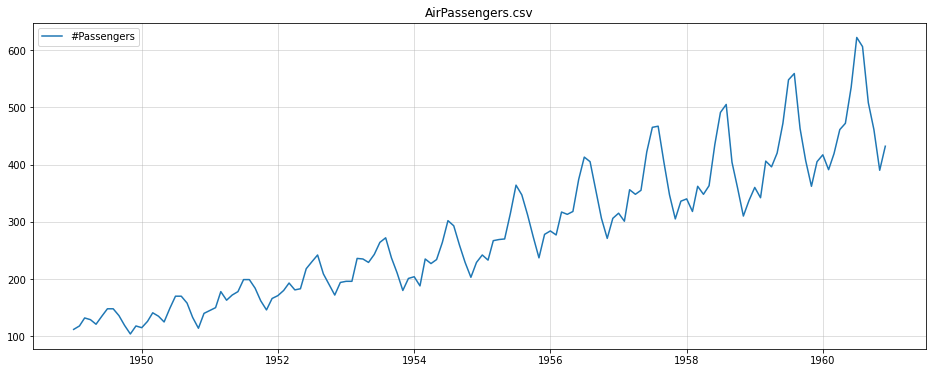

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/AirPassengers.csv")
df.index = pd.to_datetime(df["Month"])

y = df["#Passengers"]

plt.figure(figsize = (16,6))
plt.plot(y,label = "#Passengers")
plt.grid(alpha = 0.5)
plt.title("AirPassengers.csv")
plt.legend();

While the data is heavily outdated, it is simplistic enough to help us make a point quickly.

### Hitting time point predictions
First let us consider how to solve the hitting time problem using a standard point forecast. In the end, we can only determine when our forecast hits a certain threshold deterministically.

Here, I chose the arbitrary threshold of **550 passengers**. For a fictitious airline company behind the data, this could give an important clue for when to increase fleet capacity.

For the point forecast approach, the procedure is now straightforward:

1. Fit an arbitrary time-series model (Here we'll use a SARIMAX (12,1,1,1) model to capture trend and yearly seasonality).
2. Forecast over a horizon that is sufficiently long for the time-series to exceed the given threshold.
3. Mark the timestamp where the forecast exceeds the threshold for the first time as your hitting time.

With `statsmodels.tsa.sarimax.SARIMAX`, this looks as follows:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


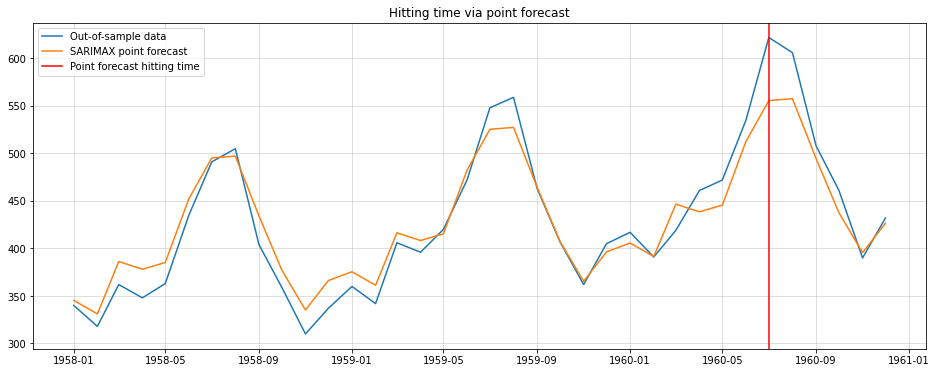

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

y_train = y.iloc[:-36]
y_test = y.iloc[-36:]

model = SARIMAX(endog = y_train,
                order = (1,1,1),
                seasonal_order=(0,1,0,12)).fit(disp=0)


point_forecast = model.forecast(36)


plt.figure(figsize=(16,6))
plt.plot(y_test, label="Out-of-sample data")
plt.plot(point_forecast, label="SARIMAX point forecast")
plt.axvline(point_forecast.index[np.argmax(point_forecast>=550)], color="red", label="Point forecast hitting time")
plt.grid(alpha=0.5)

plt.title("Hitting time via point forecast")
plt.legend();

Looking at the out-of-sample set in hindsight, we see that our hitting time forecast was one year late. In a real-world application, being one year late could be arbitrarily bad for your business case.

As we will see, the probabilistic variant gives a much more complete picture. Unfortunately, we cannot calculate the respective probability mass function in closed form.

### Monte-Carlo estimation of hitting time probabilities
Luckily, `statsmodels`' SARIMAX provides both mean and standard deviation forecasts. As the forecast distribution is Gaussian, we can use that knowledge for  a [Monte-Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method?ref=sarem-seitz.com). From there, we can estimate the probability for each month being the hitting time for `C=550`:

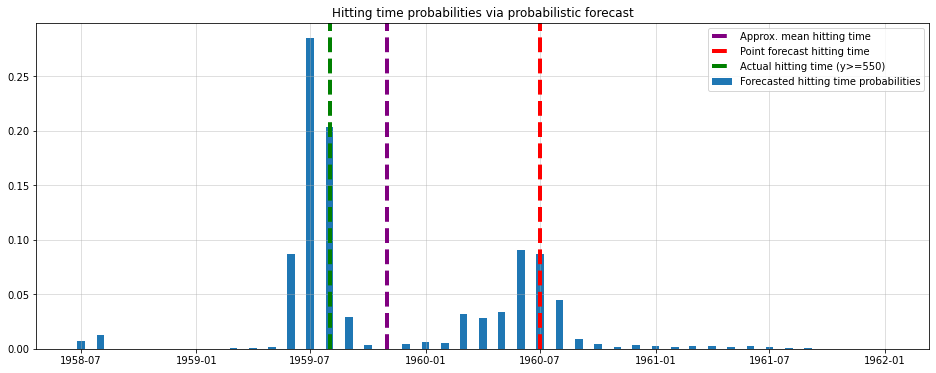

In [3]:
import numpy as np
from scipy.stats import norm

means = model.get_forecast(100).predicted_mean
stds = model.get_forecast(100).se_mean

np.random.seed(123)
hits = [np.argmax(norm(means,stds).rvs()>=550) for _ in range(10000)]
hit_dates = [means.index[hit] for hit in hits]

probs = pd.Series(hit_dates).value_counts()/10000

plt.figure(figsize=(16,6))
plt.bar(probs.index, probs.values,width=12, label = "Forecasted hitting time probabilities")

plt.axvline(means.index[int(np.mean(hits))], color="purple",label = "Approx. mean hitting time", lw=4, ls="dashed")
plt.axvline(means.index[np.argmax(model.forecast(36)>=550)],color="red", label = "Point forecast hitting time", lw=4, ls="dashed")
plt.axvline(means.index[np.argmax(y_test>=550)],color="green", label = "Actual hitting time (y>=550)", lw=4, ls="dashed")
plt.grid(alpha = 0.5)

plt.title("Hitting time probabilities via probabilistic forecast")
plt.legend();

This looks much better. Our model predicts that the time-series will is most likely to exceed the threshold one year before the point forecast prediction. The hindsight data also agrees much better with this prediction.

Additionally, we see that the point forecast hitting time (red line) is not the expectation (purple line) of the probabilistic variant either. This is significant in so far as the point forecast of the actual time-series is in fact the mean of the probabilistic forecast.

Due to the underlying dynamic of SARIMAX, however, this does not translate to the mean hitting time.

Finally, let us look at the Cumulative Distribution Function of our mass function estimate:

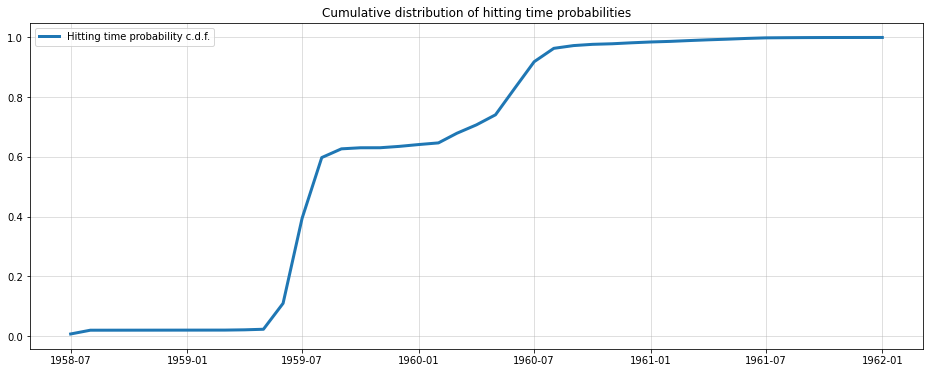

In [4]:
plt.figure(figsize=(16,6))
plt.plot(probs.sort_index().cumsum(), lw=3, label="Hitting time probability c.d.f.")
plt.grid(alpha = 0.5)

plt.legend()
plt.title("Cumulative distribution of hitting time probabilities");

Here, the probability of threshold exceedance is already beyond 60% by the second year and not the third. Another reason why the point forecast hitting time is inappropriate.

## Conclusion
While working with point forecasts is often more convenient, such complexity reduction can be too much in some instances. Even in this rather simple example, the 'simple' approach was already off by one year.

Certainly, your particular hitting time problem might allow you to go the straightforward route. Keep in mind, however, that you will only be able to judge quality of your forecast after the fact. By then it will obviously be too late to switch to the more sophisticated but also more holistic approach discussed above.

In the end, a probabilistic forecast can always be reduced to a single point-forecast. Vice-versa, this is unfortunately not the case. Personally, I can more than recommend the probabilistic route as there are many other advantages to it.

In future articles, I am planning to provide more insights about those other advantages. If you are interested, feel free to subscribe to get notified by then.

## References
**[1]** Bas, Esra. Basics of Probability and Stochastic Processes. Springer International Publishing, 2019.

**[2]** Hamilton, James Douglas. Time series analysis. Princeton university press, 2020.

**[3]** Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018.